In [1]:
pip install fredapi

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
import yfinance as yf
from fredapi import Fred
from scipy.optimize import minimize
from scipy import stats
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

Risk-Free Rate: 0.0483
Please enter the asset tickers (comma-separated, e.g., AAPL, MSFT, GOOGL): MSFT, GOOG, AMZN, NVDA, TSLA, JPM, GS, MS, KO, JNJ, PG, VOO, VTI, VCIT, VWO, GLD, BND, AAPL, QQQ, SPY


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Optimal Weights: {'MSFT': 0.0, 'GOOG': 4.545559881040741e-15, 'AMZN': 0.0, 'NVDA': 0.1051173979629248, 'TSLA': 2.7051739082913672e-14, 'JPM': 0.07635722014048717, 'GS': 0.061491237150639345, 'MS': 0.0, 'KO': 0.431676673224006, 'JNJ': 0.0, 'PG': 0.02501515673200353, 'VOO': 0.0, 'VTI': 0.0, 'VCIT': 0.09628559241911631, 'VWO': 0.0, 'GLD': 0.20405672237085065, 'BND': 0.0, 'AAPL': 0.0, 'QQQ': 0.0, 'SPY': 0.0}
Expected Annual Return: 0.3990
Expected Volatility: 0.0868
Sharpe Ratio: 4.0398
Risk-Free Rate: 0.0483
Value at Risk (VaR) at 95.0% confidence level: 0.01



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


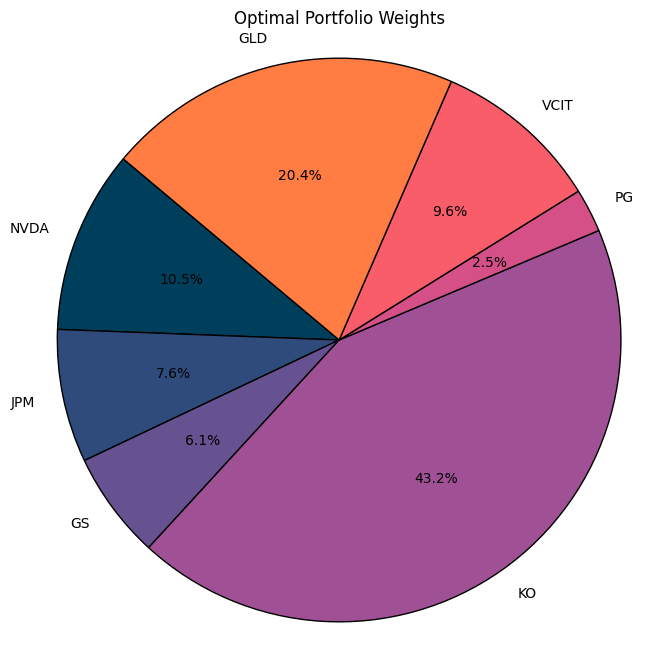

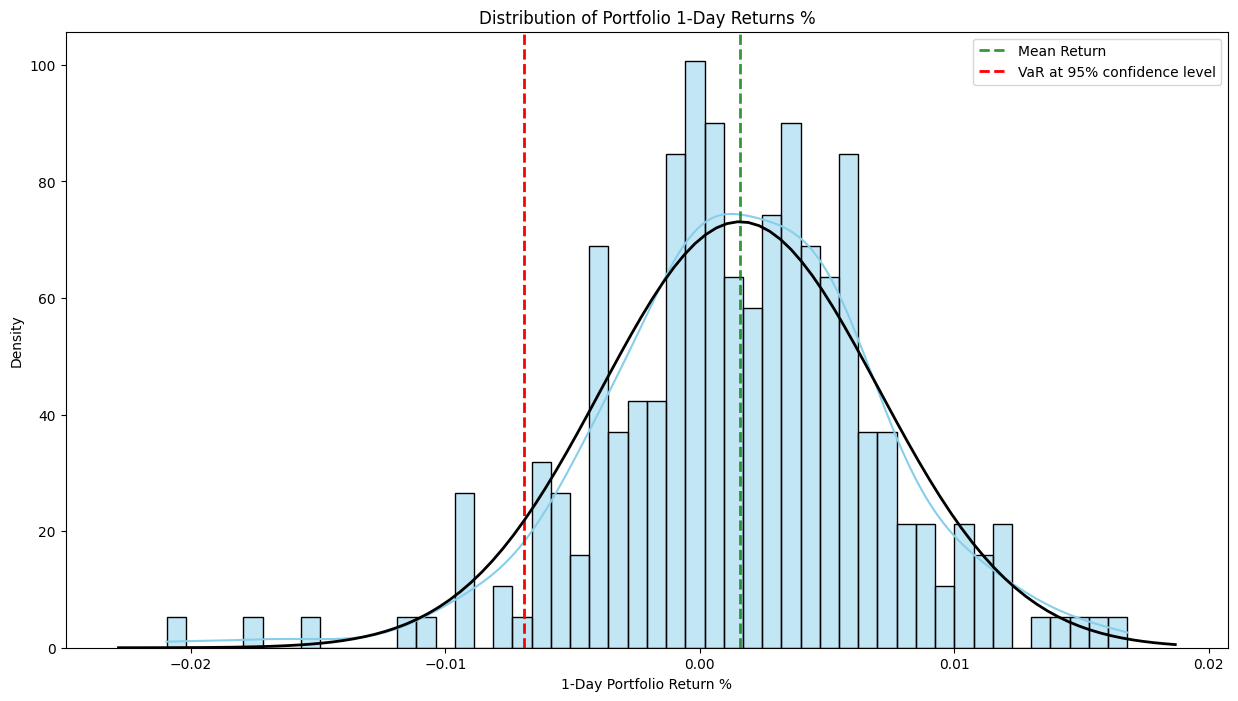

In [15]:
# Get risk-free rate
fred = Fred(api_key='YOUR API KEY')
risk_free_rate = fred.get_series_latest_release('DFF') / 100
risk_free_rate = risk_free_rate.iloc[-1]
print(f"Risk-Free Rate: {risk_free_rate:.4f}")

# Define asset list and date range
tickers_input = input("Please enter the asset tickers (comma-separated, e.g., AAPL, MSFT, GOOGL): ")
tickers = [ticker.strip() for ticker in tickers_input.split(",")]
end_date = datetime.today()
start_date = end_date - timedelta(days=365)

# Get adjusted close prices
adj_close_df = pd.DataFrame({ticker: yf.download(ticker, start=start_date, end=end_date)['Adj Close'] for ticker in tickers})
adj_close_df.ffill(inplace=True)  # Forward fill missing values

# Calculate log returns
log_returns = np.log(adj_close_df / adj_close_df.shift(1)).dropna()
cov_matrix = log_returns.cov() * 252

# Define optimization functions
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

def expected_return(weights, log_returns):
    return np.sum(log_returns.mean() * weights) * 252

def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

# Constraints: Weights must sum to 1
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}

# Bounds: Each weight must be between 0 and 0.25 (25%)
max_weight = 1
bounds = [(0, max_weight) for _ in range(len(tickers))]

# Initial weights: Assuming equal distribution
initial_weights = np.array([1 / len(tickers)] * len(tickers))

# Perform optimization
optimized_results = minimize(neg_sharpe_ratio, initial_weights,
                             args=(log_returns, cov_matrix, risk_free_rate),
                             method='SLSQP', constraints=constraints,
                             bounds=bounds)

# Retrieve optimal portfolio details
optimal_weights = optimized_results.x
optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

# Calculate VaR
portfolio_size = 1  # Adjust this as needed for your calculations
confidence_level = 0.95
days = 1

historical_returns = (log_returns * optimal_weights).sum(axis=1)
range_returns = historical_returns.rolling(window=days).sum().dropna()
VaR = -np.percentile(range_returns, 100 - (confidence_level * 100)) * portfolio_size

# Print portfolio details and VaR
print(f"Optimal Weights: {dict(zip(tickers, optimal_weights))}")
print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")
print(f"Risk-Free Rate: {risk_free_rate:.4f}")
print(f"Value at Risk (VaR) at {confidence_level * 100}% confidence level: {VaR:.2f}")

# Cumulative returns for the optimized portfolio
cumulative_portfolio_returns = (1 + historical_returns).cumprod() * portfolio_size

# Fetch historical data for each benchmark and calculate cumulative values
benchmarks = {
    'S&P 500': '^GSPC',
    'MSCI World Index': 'URTH',
    'FTSE 100': '^FTSE',
    'Nikkei 225': '^N225',
    'DAX': '^GDAXI'
}

for name, ticker in benchmarks.items():
    benchmark_data = yf.download(ticker, start=start_date, end=end_date)
    benchmark_data.ffill(inplace=True)
    benchmark_returns = np.log(benchmark_data['Adj Close'] / benchmark_data['Adj Close'].shift(1)).dropna()
    cumulative_benchmark_returns = (1 + benchmark_returns).cumprod() * portfolio_size

# Display Allocation as a pie chart for allocations >= 1%
filtered_weights = [weight for weight in optimal_weights if weight >= 0.01]
filtered_tickers = [ticker for i, ticker in enumerate(tickers) if optimal_weights[i] >= 0.01]

custom_colors = [
    '#003f5c', '#2f4b7c', '#665191', '#a05195', '#d45087',
    '#f95d6a', '#ff7c43', '#ffa600', '#f0f921', '#c2f9eb',
    '#9be5f4', '#71c9f8', '#47aef0', '#2186eb', '#1d6ebf',
    '#195190', '#163163', '#122536', '#0e1222', '#08141e'
]

plt.figure(figsize=(8, 8))
plt.pie(filtered_weights, labels=filtered_tickers,
        autopct='%1.1f%%', startangle=140,
        colors=custom_colors,
        wedgeprops={'edgecolor': 'black'})
plt.axis('equal')
plt.title('Optimal Portfolio Weights')
plt.show()

# Calculate mean return for VaR distribution plot
mean_return = range_returns.mean()

# Display VaR distribution with mean return and best fit curve
plt.figure(figsize=(15, 8))
sns.histplot(range_returns * portfolio_size, bins=50,
             kde=True, stat='density', color='skyblue')
plt.xlabel(f'{days}-Day Portfolio Return %')
plt.ylabel('Density')
plt.title(f'Distribution of Portfolio {days}-Day Returns %')
plt.axvline(mean_return * portfolio_size,
            color='g', linestyle='dashed',
            linewidth=2, label='Mean Return', alpha=0.8)
plt.axvline(-VaR,
            color='r', linestyle='dashed',
            linewidth=2,
            label=f'VaR at {confidence_level:.0%} confidence level')
plt.legend()

# Fit a normal distribution to the data and plot it
mu, std = norm.fit(range_returns * portfolio_size)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

plt.show()

Minimum Variance Portfolio Weightings:
MSFT: 0.03592865682384982
GOOG: 0.0019231475010388034
AMZN: 0.04264547401429508
NVDA: 0.00487069393791473
TSLA: 0.003276103169181003
JPM: 0.0237867407492588
GS: 0.05459737849444626
MS: 0.001589313036332308
KO: 0.06775168965838335
JNJ: 0.043802862435805986
PG: 0.09010748087802549
VOO: 0.025905850628649953
VTI: 0.09575032086554061
VCIT: 0.10425087838457456
VWO: 0.034280308262724865
GLD: 0.06887090650115675
BND: 0.10286910775890966
AAPL: 0.016870326477961595
QQQ: 0.08169676043196537
SPY: 0.09922599998998498


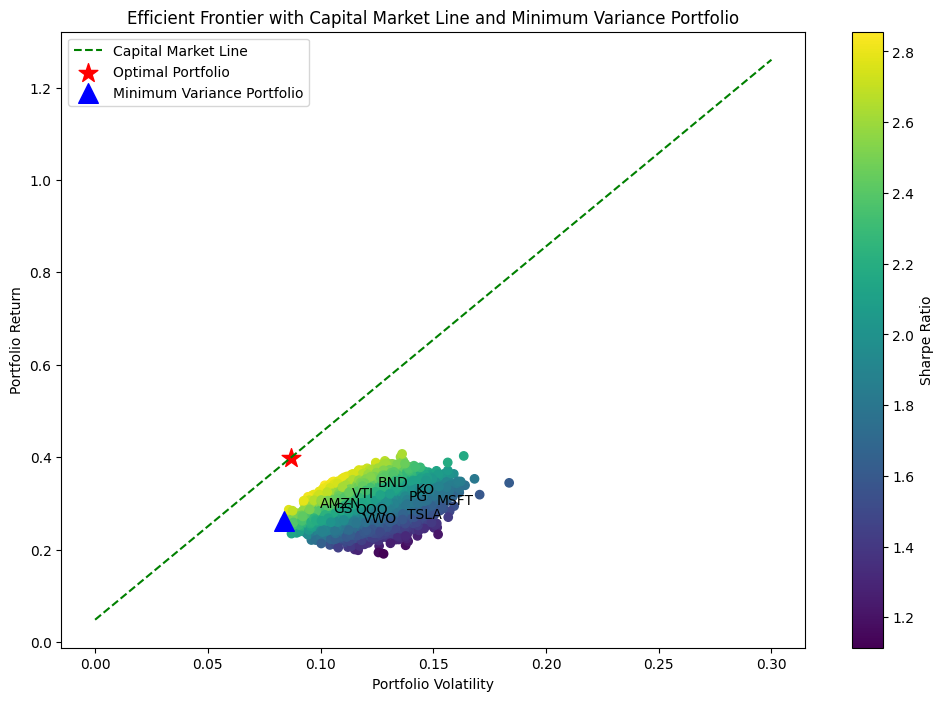

In [16]:
# Number of random portfolios to generate
num_portfolios = 10000

# Generate random portfolios
random_portfolios = np.random.rand(num_portfolios, len(tickers))
random_portfolios = random_portfolios / random_portfolios.sum(axis=1)[:, None]  # Ensure weights sum up to 1

# Calculate returns and volatility for random portfolios
portfolio_returns = np.array([expected_return(weights, log_returns) for weights in random_portfolios])
portfolio_volatilities = np.array([standard_deviation(weights, cov_matrix) for weights in random_portfolios])
portfolio_sharpe_ratios = (portfolio_returns - risk_free_rate) / portfolio_volatilities

# Save the simulation results to CSV files
simulation_results_df = pd.DataFrame({
    'Weights': list(random_portfolios),
    'Returns': portfolio_returns,
    'Volatility': portfolio_volatilities,
    'Sharpe Ratio': portfolio_sharpe_ratios
})

# Convert weights to a DataFrame with appropriate column names
weights_df = pd.DataFrame(random_portfolios, columns=[f'Weight_{ticker}' for ticker in tickers])
simulation_results_df = pd.concat([weights_df, simulation_results_df], axis=1)

# Save to CSV
simulation_results_df.to_csv('random_portfolio_simulations.csv', index=False)

# Calculate the Capital Market Line (CML)
rf_rate = risk_free_rate
cml_x = np.linspace(0, 0.3, 50)  # Adjust the range based on your data
cml_y = rf_rate + (optimal_sharpe_ratio * cml_x)

min_var_portfolio_index = np.argmin(portfolio_volatilities)
min_var_portfolio_volatility = portfolio_volatilities[min_var_portfolio_index]
min_var_portfolio_return = portfolio_returns[min_var_portfolio_index]
min_var_portfolio_weights = random_portfolios[min_var_portfolio_index]

# Plot the efficient frontier with the Capital Market Line and the Minimum Variance Portfolio
plt.figure(figsize=(12, 8))
plt.scatter(portfolio_volatilities, portfolio_returns, c=portfolio_sharpe_ratios, cmap='viridis')
plt.plot(cml_x, cml_y, color='green', linestyle='--', label='Capital Market Line')
plt.title('Efficient Frontier with Capital Market Line and Minimum Variance Portfolio')
plt.xlabel('Portfolio Volatility')
plt.ylabel('Portfolio Return')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(optimal_portfolio_volatility, optimal_portfolio_return, color='red', marker='*', s=200, label='Optimal Portfolio')
plt.scatter(min_var_portfolio_volatility, min_var_portfolio_return, color='blue', marker='^', s=200, label='Minimum Variance Portfolio')

# Add ticker labels without overlap
for i in range(len(tickers)):
    if i % 2 == 0:  # Display every other ticker
        plt.text(portfolio_volatilities[i], portfolio_returns[i], tickers[i])

plt.legend()

# Print the weightings of the Minimum Variance Portfolio
print("Minimum Variance Portfolio Weightings:")
for i, ticker in enumerate(tickers):
    print(f"{ticker}: {min_var_portfolio_weights[i]}")

plt.show()